# Regresión Logística

El regresor logístico es un modelo que mapea una o más variables continuas a una variable objetivo binaria

Matemáticamente el modelo se define como

$$
f_\theta(\vec x_i) = \mathcal{S} \left(\theta_0 + \sum_{j=1}^M \theta_j x_{ij}\right) 
$$

donde $\theta_0, \theta_1, \ldots, \theta_M$ son los parámetros del modelo y $\mathcal{S}(z) = \frac{1}{1+\exp(-z)}$ se conoce como función logística o sigmoide

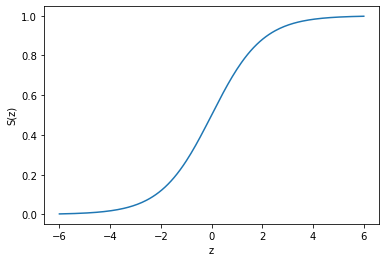

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

z = np.linspace(-6, 6, num=200)
sigmoid = lambda z: 1./(1+np.exp(-z))

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(z, sigmoid(z))
ax.set_xlabel('z')
ax.set_ylabel('S(z)');

Luego

- $f_\theta(\vec x_i)$ puede interpretarse como la probabilidad de que $x_i$ pertenezca  a la clase "1"
- $1-f_\theta(\vec x_i)$ puede interpretarse como la probabilidad de que $x_i$ pertenezca a la clase "0"

El modelo implementado en NumPy:

In [2]:
def logistic_regressor(theta, x):
    z = theta[0] + np.dot(x, theta[1:])
    return sigmoid(z)

Consideremos el siguiente conjunto de datos sintético de dos dimensiones:

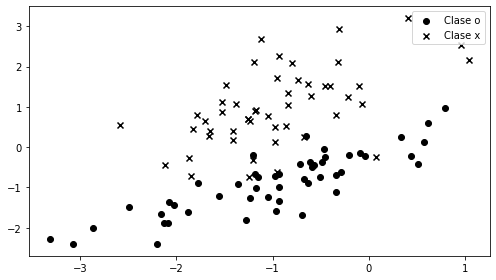

In [3]:
from sklearn.datasets import make_classification
np.random.seed(20)
X, y = make_classification(n_features=2, n_classes=2, n_informative=2, 
                           n_redundant=0, n_clusters_per_class=1)

fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
for y_, marker in zip(np.unique(y), ['o', 'x']):
    mask = y == y_
    ax.scatter(X[mask, 0], X[mask, 1], c='k', marker=marker, label=f'Clase {marker}')
ax.legend();

Consideremos un modelo con los siguientes parámetros

In [4]:
theta = np.array([-2.5, -3.3, 5.])

La predicción del modelo en este espacio sería: 

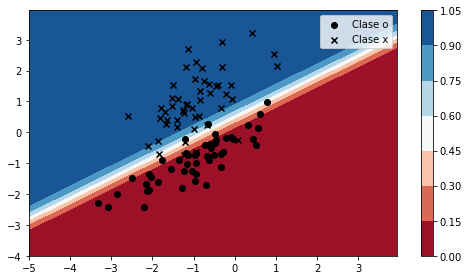

In [5]:
def plot_prediction(ax, theta, plot_data=True, colorbar=False):
    xx1, xx2 = np.meshgrid(np.arange(-5, 4, 0.05), np.arange(-4, 4, 0.05))
    preds = logistic_regressor(theta, np.stack((xx1.ravel(),xx2.ravel())).T)
    artist = ax.contourf(xx1, xx2, preds.reshape(xx1.shape), cmap=plt.cm.RdBu)
    if colorbar:
        fig.colorbar(artist, ax=ax)
    if plot_data:
        for y_, marker in zip(np.unique(y), ['o', 'x']):
            mask = y == y_
            ax.scatter(X[mask, 0], X[mask, 1], c='k', marker=marker, label=f'Clase {marker}')
        ax.legend();

fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
plot_prediction(ax, theta, colorbar=True)

> ¿Cómo se llega a estos valores para $\theta$?

Para entrenar este modelo se utiliza la siguiente función de costo 

$$
L(\theta) = \sum_{i=1}^N  -y_i \log( f_\theta(\vec x_i) ) - (1-y_i) \log(1 - f_\theta(\vec x_i))
$$

conocida como la **Entropía Cruzada Binaria** (*binary cross entropy*). En NumPy esto sería:



In [6]:
def bce_loss(theta, x, y, eps=1e-10):
    ypred = logistic_regressor(theta, x)
    return -np.sum(y*np.log(ypred+eps) + (1.-y)*np.log(1.-ypred+eps), axis=0)

El gradiente de la función de costo es

$$
\begin{split}
\frac{d}{d \theta_j} L(\theta) &= \sum_{i=1}^N  \left(-\frac{y_i}{f_\theta(\vec x_i)} + \frac{1-y_i}{1 - f_\theta(\vec x_i)}\right) \frac{f_\theta(\vec x_i)}{d\theta_j}  \\
&= \begin{cases}-\sum_{i=1}^N (y_i - f_\theta(\vec x_i)) x_{ij} &j>0\\
-\sum_{i=1}^N (y_i - f_\theta(\vec x_i)) & j=0 \\
\end{cases}
\end{split}
$$

En NumPy sería:

In [7]:
def grad_bce_loss(theta, x, y):
    ypred = logistic_regressor(theta, x)
    error = y - ypred
    D = np.ones(shape=(X.shape[0], 3))
    D[:, 1:] = x
    return -np.dot(error, D)

:::{warning}

A diferencia de la regresión lineal no podemos despejar analiticamente $\theta$ debido a la no linealidad de $f_\theta(\vec x_i)$

:::

Para entrenar este modelo se utilizan métodos de optimización iterativos, como los que se presentan a continuación

## Método de Newton y Gradiente descedente

Sea el valor actual del vector de parámetros $\theta_t$

Queremos encontrar el mejor "próximo valor" según nuestra función objetivo

$$
\theta_{t+1} = \theta_t + \Delta \theta
$$

Consideremos la aproximación de Taylor de segundo orden de $f$

$$
f(\theta_{t} + \Delta \theta) \approx f(\theta_t) + \nabla f (\theta_t) \Delta \theta + \frac{1}{2} \Delta \theta^T H_f (\theta_t) \Delta \theta 
$$

Derivando en función de $\Delta \theta$ e igualando a cero tenemos

$$
\begin{split}
\nabla f (\theta_t)  +  H_f (\theta_t) \Delta \theta &= 0  \\
\Delta \theta &= - [H_f (\theta_t)]^{-1}\nabla f (\theta_t)   \\
\theta_{t+1} &= \theta_{t} - [H_f (\theta_t)]^{-1}\nabla f (\theta_t) 
\end{split}
$$

Se obtiene una regla iterativa en función del **Gradiente** y del **Hessiano** de $L(\theta)$. El gradiente nos dice la dirección de máximo descenso y el hessiano la magnitud del paso 

Cabe destacar que

- La solución depende de $\theta_0$
- Estamos asumiendo que la aproximación de segundo orden es "buena"
- Si nuestro modelo tiene $M$ parámetros el Hessiano es de $M\times M$, ¿Qué pasa si $M$ es grande?



Si el Hessiano es prohibitivo podemos usar una aproximación de primer orden conocida como el método de **gradiente descendente**

$$
\theta_{t+1} = \theta_{t} - \eta \nabla f (\theta_t)
$$

donde hemos reemplazado el Hessiano por una constante $\eta$ llamado "paso" o "tasa de aprendizaje"

:::{warning}

$\eta$ es un hiperparámetro del modelo que debe ser calibrado cuidadosamente. Un valor muy alto vuelve el entrenamiento inestable mientas que un valor muy pequeño hará que el algoritmo tome un tiempo imprácticamente largo en llegar a la solución

:::

<img src="img/gd.png" width="600">

:::{warning}

El gradiente descedente converge a un punto estacionario. Si $L(\theta)$ es no-convexo entonces el resultado podría corresponder a un mínimo local. Es importante verificar el resultado utilizando distintas valores de $\theta_0$

:::

Utilicemos el gradiente descedente para entrenar el regresor logístico, en NumPy esto sería

In [8]:
def train(nepochs=10, lr=1e-2, rseed=None):
    np.random.seed(rseed)
    theta = np.zeros(shape=(nepochs+1, 3))
    theta[0] = np.random.randn(3)
    loss = np.zeros(shape=(nepochs,))
    for epoch in range(nepochs):
        loss[epoch] = bce_loss(theta[epoch], X, y)
        theta[epoch+1] = theta[epoch] - lr*grad_bce_loss(theta[epoch], X, y)
    return loss, theta

loss, theta = train(rseed=12345)

La evolución de la función de costo y el valor de los parámetros

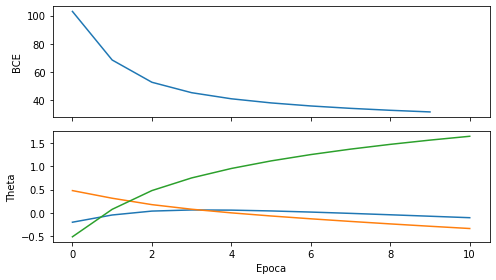

In [9]:
fig, ax = plt.subplots(2, figsize=(7, 4), tight_layout=True, sharex=True)
ax[0].plot(loss)
ax[0].set_ylabel('BCE')
for param in theta.T:
    ax[1].plot(param)
ax[1].set_ylabel('Theta')
ax[1].set_xlabel('Epoca');

Y en este caso, con datos bidimensionales, podemos visualizar como se ajusta el plano separador época a época

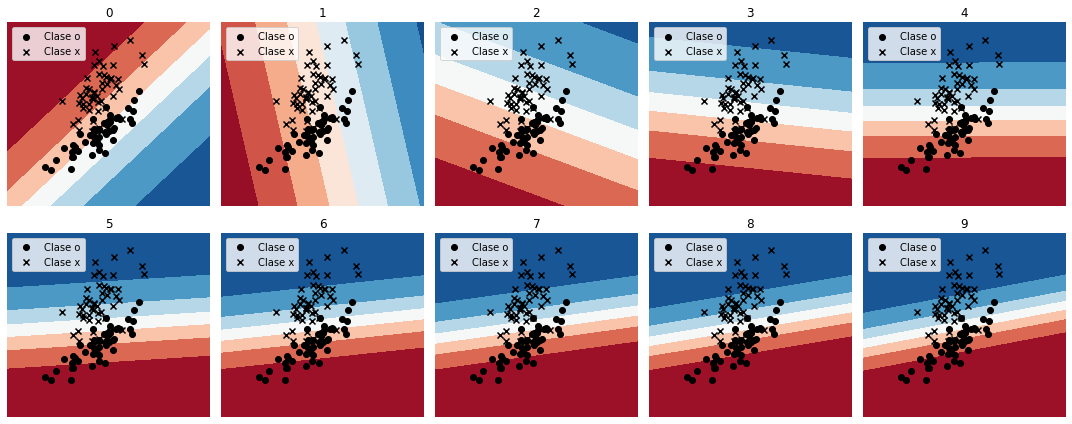

In [10]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True, tight_layout=True)
for k, ax_ in enumerate(ax.ravel()):
    ax_.axis('off')
    plot_prediction(ax_, theta[k, :])
    ax_.set_title(k)

## Regresor logístico en Scikit-Learn

En scikit-learn el regresor logístico está implementado en [`sklearn.linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Los principales argumentos son

- `penalty`: Tipo de regularización, por ejemplo `l2`, `l1` o `'none'`
- `tol`: Tolerancia para el criterio de detención
- `solver`: El algoritmo de optimización a utilizar, por defecto se usa `lbfgs` un método quasi-Newton
- `max_iter`: Número máximo de épocas
- `n_jobs`: Núcleos de CPU a utilizar 


Los principales métodos son

- `fit(X, y)`: Entrenar el modelo con una base de datos `X` y etiquetas `y`
- `predict_proba(X)`: Retorna las probabilidades de clase para los ejemplos `X`
- `predict(X)`: Retorna la clase de mayor probabilidad de `X`

Y los principales atributos son

- `intercept_`: Corresponde a $\theta_0$
- `coef_`: Es un arreglo con $\theta_j$ para $j>0$


Lo siguiente es equivalente a la implementación manual que se mostró anteriormente

In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='none')
model.fit(X, y)

print(model.intercept_, model.coef_)

[-2.44751183] [[-3.3470849   4.81780968]]


A continuación se muestra la diferencia entre `predict` y `predict_proba` para un dato ubicado en [1., 0.]

In [12]:
display(model.predict_proba(np.array([[1., 0.]])), 
        model.predict(np.array([[1., 0.]])))

array([[0.99696528, 0.00303472]])

array([0])

:::{note}

La predicción dura (predict) es equivalente al argumento máximo de la predicción probabilística (predict_proba)

:::


In [13]:
np.allclose(np.argmax(model.predict_proba(X), axis=1), 
            model.predict(X))

True

A continuación se muestra graficamente la diferencia entre la predicción dura y la predicción probabilística:

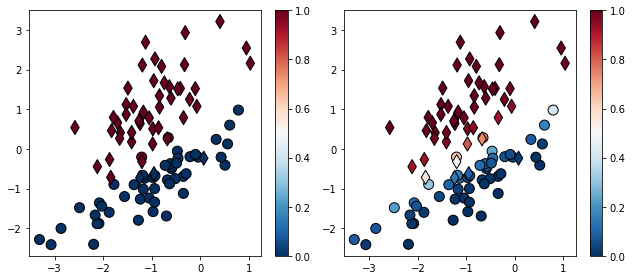

In [14]:
y_soft = model.predict_proba(X)[:, 1]
y_hard = model.predict(X)

fig, ax = plt.subplots(1, 2, figsize=(9, 4), tight_layout=True)

for ax_, pred in zip(ax, [y_hard, y_soft]):
    for y_, marker in zip(np.unique(y), ['o', 'd']):
        mask = y == y_
        artist = ax_.scatter(X[mask, 0], X[mask, 1], c=pred[mask], marker=marker, s=100,
                             vmin=0, vmax=1, cmap=plt.cm.RdBu_r, edgecolors='k', linewidths=1)
    fig.colorbar(artist, ax=ax_);

El tipo de símbolo corresponde a la etiqueta real mientras que el color corresponde a la etiqueta predicha

:::{note}

En la próxima lección veremos como evaluar cuantitativamente el desempeño de un clasifidor

:::